<a href="https://colab.research.google.com/github/amirhoseinaghaei/Image-Captioning-/blob/main/Image_Captioning_For_Flicker_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
import numpy as np 
import pickle
import tensorflow as tf
from tensorflow.keras import models , Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tqdm import tqdm 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Conv2D , MaxPooling2D   , Flatten
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.model_selection import train_test_split
 

## Getting dataset from google drive

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
BASE_DIR = "gdrive/MyDrive/Flicker_Dataset"
WORKING_DIR  = "gdrive/MyDrive/Image_Captioning_Project "

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Load Flicker dataset images and extract the features with VGG16 model 

In [3]:
# Loading the flicker-dataset images and extracting featueres
from tqdm import tqdm
features = {}
images = {}
img_list = []
directory = os.path.join(BASE_DIR, "Images")
with open(os.path.join(WORKING_DIR , "images.pkl"), "rb") as f:
    images = pickle.load(f)
# for img_name in tqdm(os.listdir(directory)):
#   image_path = directory  + "/" + img_name
#   image = load_img(image_path , target_size= (224,224))
#   image = img_to_array(image) 
#   image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
#   # feature = model.predict(image)
#   # img_list.append(image)
#   image_id = img_name.split(".")[0]
#   images[image_id] = image
#   # features[image_id]  = feature


In [48]:
# new_images = {}
# i = 0
# for key, value in images.items():
#     i += 1
#     if i == 8093:
#       break
#     new_images[key] = value
print((images["109823394_83fcb735e1"][0]))


[[[ 47.  44.  37.]
  [ 42.  44.  33.]
  [ 59.  50.  43.]
  ...
  [ 46.  52.  52.]
  [ 73.  77.  89.]
  [ 72.  72.  84.]]

 [[ 42.  43.  29.]
  [ 29.  34.  28.]
  [ 54.  43.  41.]
  ...
  [119. 121. 133.]
  [132. 131. 145.]
  [132. 131. 145.]]

 [[ 54.  51.  46.]
  [ 32.  42.  33.]
  [ 59.  56.  41.]
  ...
  [ 73.  78.  81.]
  [129. 130. 135.]
  [105. 110. 114.]]

 ...

 [[108.  60.  38.]
  [116.  94.  53.]
  [ 95.  78.  58.]
  ...
  [158. 151. 107.]
  [144. 122.  98.]
  [115.  97.  73.]]

 [[ 78.  74.  62.]
  [107.  66.  44.]
  [ 91.  84.  68.]
  ...
  [166. 151. 112.]
  [146. 122.  84.]
  [118.  98.  61.]]

 [[155. 140. 107.]
  [ 72.  72.  44.]
  [162. 137.  97.]
  ...
  [ 46.  33.  24.]
  [ 78.  61.  43.]
  [ 91.  75.  52.]]]


In [4]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
  X1, X2, y = list(), list(), list()
  # walk through each image identifier
  for key, desc_list in descriptions.items():
    # walk through each description for the image
    for desc in desc_list:
      # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
         # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
    if key != "":
      X1.append((photos[key][0]))
      X2.append(in_seq)
      y.append(out_seq)
  return (X1), (X2), (y)

## Save the extracted features 

In [5]:
# saving features dictionary in pkl file 
import pickle
pickle.dump(images , open(os.path.join(WORKING_DIR , "images.pkl"), "wb"))

KeyboardInterrupt: ignored

## Loading Captions for each image

In [6]:
from IPython.utils.text import string
def load_captions(path):
  with open(path, 'r') as f: 
    next(f)
    captions = f.read()
  mapping = {}
  line = captions.split("\n")
  for i in line:
    splitted = i.split(",")
    if len(line) < 2:
      continue
    img_id = splitted[0].split(".")[0]
    # print(splitted[1])
    caption = splitted[1:]
    caption = " ".join(caption)
    if img_id not in mapping.keys():
      mapping[img_id] = []
    # print(image_id + ": " + caption)
    mapping[img_id].append(caption)
  return mapping
descriptions = load_captions(os.path.join(BASE_DIR, "captions.txt"))
def clean_Descriptions(descriptions):
  table = str.maketrans('','',string.punctuation)
  for key, value in descriptions.items():
    for i in range(len(value)):
      text = descriptions[key][i]
      text = text.lower()
      text = text.translate(str.maketrans('', '', string.punctuation))
      text = text.split()
      text = [ele for ele in text if len(ele) > 1]
      text = [ele for ele in text if (ele).isalpha()]
      text = ' '.join(text)
      descriptions[key][i] = text
  return descriptions
descriptions = clean_Descriptions(descriptions)

## Finding the vocabulary size of captions

In [6]:
def Find_Vocab_Size(descriptions):
  Vocabulary = set()
  for key in descriptions.keys():
    for i in descriptions[key]:
      Vocabulary.update(i.split())
  return Vocabulary
vocab_size = (len(Find_Vocab_Size(descriptions)))

## Visualizing 10 images with their captions


  0%|          | 0/8101 [00:00<?, ?it/s]



Image : 386655611_1329495f97.jpg
386655611_1329495f97.jpg's captions are as below:


NameError: ignored

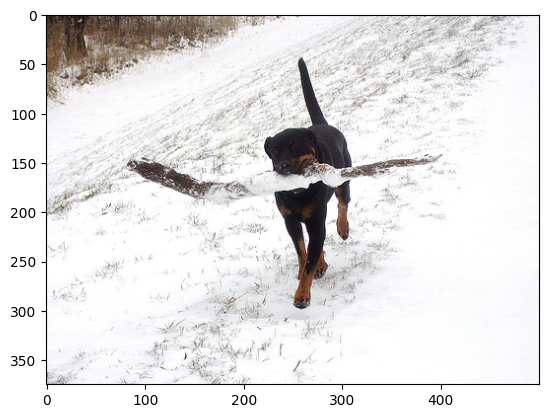

In [7]:
i = 0 
for img_name in tqdm(os.listdir(directory)):
  i += 1
  image_path = directory + "/" + img_name 
  image = mpimg.imread(image_path)
  print(f"\nImage : {img_name}")
  plt.imshow(image)
  print(f"{img_name}'s captions are as below:")
  image_id = img_name.split(".")[0]
  print(mapping[image_id])
  if i == 10: 
    break

## Defining the model

In [3]:
from tensorflow.python.keras.layers.merge import Add
from tensorflow.python.ops.gen_array_ops import InplaceAdd
from keras.backend import conv2d

from keras import optimizers
from tensorflow.python.ops.nn_ops import relu
def Build_CNN_FeatureExtractor(vocab_size):
      input1 = Input(shape=(224,224,3))
      conv1 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(input1)
      conv2 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(conv1)
      max1 =  MaxPooling2D((2,2), (2,2))(conv2)
      conv3 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(max1)
      conv4 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(conv3)
      max2 =  MaxPooling2D((2,2), (2,2))(conv4)
      conv5 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(max2)
      conv6 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv5)
      conv7 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv6)
      max3 =  MaxPooling2D((2,2), (2,2))(conv7)
      conv8 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max3)
      conv9 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv8)
      conv10 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv9)
      max4 =  MaxPooling2D((2,2), (2,2))(conv10)
      conv11 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max4)
      conv12 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv11)
      conv13 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv12)
      max5 =  MaxPooling2D((2,2), (2,2))(conv13)
      flatten = Flatten()(max5)
      dense1 = Dense(4096, activation = tf.nn.relu)(flatten)
      dropout1 = Dropout(0.4)(dense1)
      dense2 = Dense(4096)(dropout1)
      dense3 = Dense(256)(dense2)
      input2 = Input(shape = (35,))
      embedding = Embedding(input_dim = vocab_size, output_dim = 256)(input2)
      dropout2 = Dropout(0.4)(embedding)
      lstm = LSTM(256)(dropout2)
      added = add([dense3, lstm])
      dense4 = Dense(256 , activation = tf.nn.relu)(added)
      output = Dense(vocab_size, activation = tf.nn.softmax)(dense4)
      model = Model(inputs = [input1 , input2], outputs = output)
      return model
 
vocab_size = 8600
model = Build_CNN_FeatureExtractor(vocab_size)
optimizer = tf.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy" , metrics = ["Accuracy"] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## Plotting the model

In [8]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc


In [9]:
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
X1, X2, y = create_sequences(tokenizer, max_length(descriptions), descriptions, images, vocab_size + 1)


In [10]:
Images , Captions, Outputs = np.array(X1), np.array(X2), np.array(y)

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(Images, Captions, test_size= 0.2)

In [11]:
np.save('Images.npy', Images)
np.save('Captions.npy', Captions)
np.save('Outputs.npy', Outputs)


In [4]:
Images , Captions, Outputs = np.load('Images.npy'), np.load('Captions.npy'), np.load('Outputs.npy')